## Aim: Generate New Pokemons<br>
In this notebook we'll apply data augmentation to the original dataset to create a new dataset and we'll build, train, and test a Generative Adversarial Networks (GANs) model.  
## Author: **_Rajat Agrawal_**
## Created on: 14-07-2023
## Version: v2
### **What's different from 1.0:** More Images with Data Augmentation
### Dataset: [Pokemon Image Dataset](https://www.kaggle.com/datasets/kvpratama/pokemon-images-dataset)
### Dataset v2 (after augmentation): [Pokemon Image Dataset v2](https://www.kaggle.com/datasets/rajatvisitme/pokemon-image-dataset-v2)

# Import libraries

In [2]:
# Import all required libraries
import os
import time

# For data visualization
import matplotlib.pyplot as plt

# import cv2 for image reading and image processing
import cv2

# tensorflow - to implement neural network
import tensorflow as tf
from tensorflow.keras import layers
from tqdm import tqdm

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
#@title GDrive IDs for the Dataset
# Download Dataset from Gdrive id (if you have already uploaded on GDrive)

!gdown --id <id>

# Unzip the dataset

Note: Load the dataset `.zip` file before unzipping.

In [ ]:
# Unzip the dataset file
!unzip /content/pokemon_image_dataset.zip

# Explore the data

# name of the image:  675.jpg


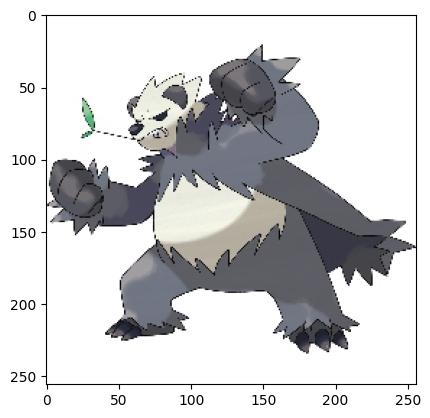

675.jpg


In [5]:
# Defining the path to dataset directory
# 'DATADIR' will hold the path to downloaded dataset.

DATADIR = "/content/pokemon_jpg/pokemon_jpg"
# Let's plot one image and see how it looks.
for img in os.listdir(DATADIR):
    img_array = cv2.imread(os.path.join(DATADIR, img))
    print("# name of the image: ", img) # name of the image
    # converting BGR to RGB as opencv read images in BGR format.
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
    plt.imshow(img_array)
    plt.show()
    print(img)
    break

## Image shape

In [6]:
# checking image shape (Not req.)
print("image shape: ", img_array.shape)

image shape:  (256, 256, 3)


# Data Augmentation

In [7]:
# Initialize the ImageDataGenerator class
# Pass the augmentation parameters in the constructor
datagen = ImageDataGenerator(
        rotation_range = 50,            # Degree range for random rotations.
        horizontal_flip = True,         # Randomly flip inputs horizontally.
        brightness_range = (0.3, 1.7),  # Range for picking a brightness shift value from.
        shear_range = 0.8,              # Shear Intensity (Shear angle in counter-clockwise direction in degrees)
        zoom_range = 0.2                # Range for random zoom.
)

In [16]:
!mkdir /content/pokemon_jpg_aug
AUGDATADIR = "/content/pokemon_jpg_aug"

In [9]:
# Loop through all the original images and augment them.
for img in os.listdir(DATADIR):
    img_array = cv2.imread(os.path.join(DATADIR, img))
    # print("# name of the image: ", img) # name of the image

    # converting BGR to RGB as opencv read images in BGR format.
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    # Reshape the image - extend the dimension
    img_array = img_array.reshape((1, ) + img_array.shape)
    # print(img_array.shape)

    i = 0
    for batch in datagen.flow(img_array, batch_size = 1,
                              save_to_dir = '/content/pokemon_jpg_aug',
                              save_prefix = img[:-4]+'_aug',
                              save_format = 'jpg'):
        i+=1
        if i > 9:
            break


In [ ]:
# !zip -r /content/pokemon_jpg_aug.zip /content/pokemon_jpg_aug

In [14]:
# # personal code
# from google.colab import drive
# drive.mount('/content/drive')
# #-----
# import shutil

# shutil.copy("/content/pokemon_jpg_aug.zip","/content/drive/MyDrive/PokeGAN")

Mounted at /content/drive


'/content/drive/MyDrive/PokeGAN/pokemon_jpg_aug.zip'

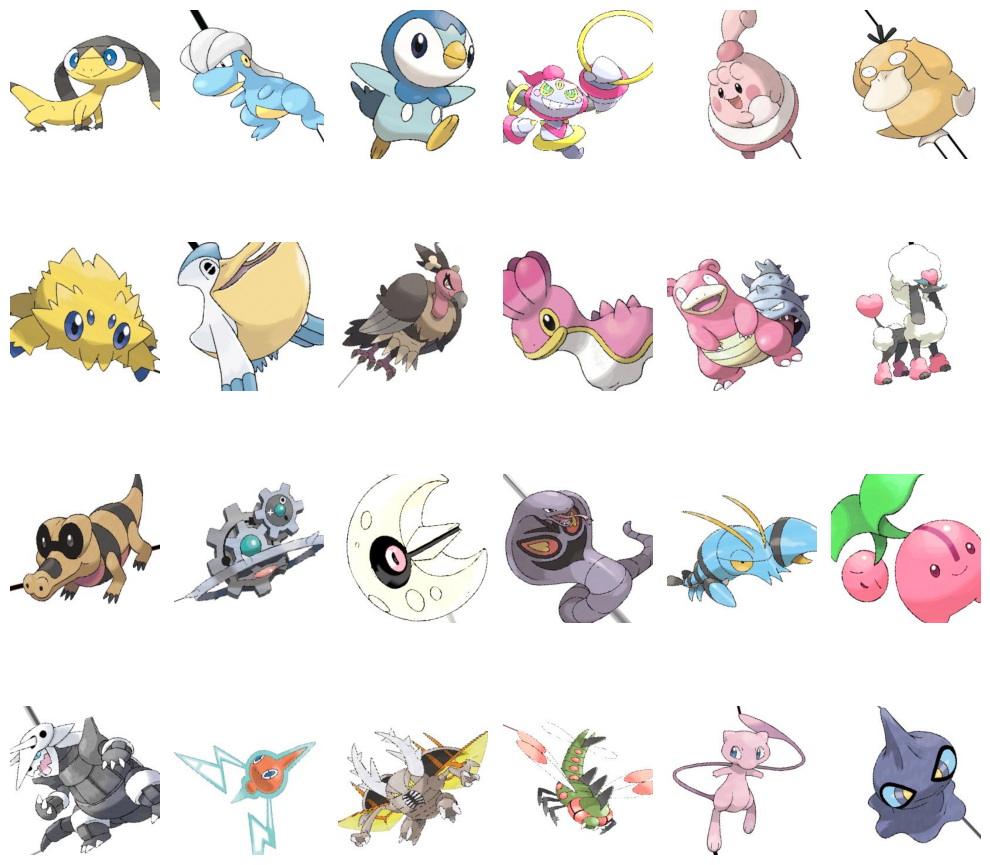

In [15]:
# Let's have a look at some augmented images.
image_directory = '/content/pokemon_jpg_aug'
images = [img for img in os.listdir(image_directory)]# if img[:7] == 'aug_ne4']

fig = plt.figure(figsize=(10, 10))  # Adjust the figure size as desired

for i, img in enumerate(images[:24]):  # Display 25 images
    img_path = os.path.join(image_directory, img)
    img_array = cv2.imread(img_path)
    img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

    ax = plt.subplot(4, 6, i + 1)
    plt.imshow(img_array)
    plt.axis('off')

plt.tight_layout()  # Optional: Improve spacing between subplots
plt.show()

In [ ]:
## Check if any image have a different shape than this: (256, 256, 3)
# c=0
# for img in os.listdir(DATADIR):
#     img_array_ = cv2.imread(os.path.join(DATADIR, img))
#     s_0 = img_array_.shape[0]
#     s_1 = img_array_.shape[0]
#     # print(s_0, s_1)
#     if s_0 != 256 or s_1 != 256:
#         print(img)
#     else:
#         c+=1
# print(c)

819


# Create training batches

In [20]:
batch_size = 128
IMG_HEIGHT = 256
IMG_WIDTH = 256

# Preprocessing function for image normalization and resizing
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH]) # Not required
    return image

# Load and preprocess images from the directory
# image_paths = [os.path.join(DATADIR, img) for img in os.listdir(DATADIR)]

# images path from original dataset
image_paths_orig = [os.path.join(DATADIR, img) for img in os.listdir(DATADIR)]

# images path from augmented dataset
image_paths_aug = [os.path.join(AUGDATADIR, img) for img in os.listdir(AUGDATADIR)]
# print(len(image_paths_orig), len(image_paths_aug))

# combine both paths (original and augmented data)
image_paths_comb = image_paths_orig + image_paths_aug
# print(len(image_paths_comb))

dataset = tf.data.Dataset.from_tensor_slices(image_paths_comb)
dataset = dataset.map(tf.io.read_file)
dataset = dataset.map(preprocess_image)

# Create training batches
dataset = dataset.batch(batch_size)

## Visualising a batch from the dataset

In [ ]:
plt.figure(figsize = (12, 8))

for images in dataset.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

Retrieving and plotting  a sample image from batch data and checking its shape. Note that as images are colored, third dimension(channel) is 3

In [ ]:
for batch in dataset:
    plt.imshow(batch[0])
    print(type(batch[0]))
    break

# Generator

## Random weights initializer

In [ ]:
init_weights_kernel = tf.keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

## Generator model architecture

In [ ]:
def generator_model():
    model = tf.keras.Sequential()

    model.add(layers.Input(shape = (100, )))
    model.add(layers.Dense(16 * 16 * 256))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((16, 16, 256)))

    model.add(layers.Conv2DTranspose(128, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel , use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(32, kernel_size = 4, padding = 'same', strides = 2,
                                     kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, kernel_size = 4, padding = 'same', strides = 2, activation = 'tanh',
                                     kernel_initializer = init_weights_kernel, use_bias = False))


    return model

## Building the generator model and summary is obtained

---



In [ ]:
generator = generator_model()

generator.summary()

## Check the generator

Using the (as yet untrained) generator to create an random colored image.

In [ ]:
noise = tf.random.normal([1, 100])

generated_image = generator(noise, training = False)

generated_image.shape

In [ ]:
generated_image[0, :5, :5]

In [ ]:
plt.imshow((generated_image[0, :, :, :] * 255 * 100))

# Discriminator

## Discriminator model architecture

In [ ]:
def discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Conv2D(32, kernel_size = 3, strides = 2, input_shape = (256, 256, 3), padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False ))
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.ZeroPadding2D(padding = ((0, 1), (0, 1))))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, kernel_size = 3, strides = 2, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(256, kernel_size = 3, strides=1, padding = 'same',
                            kernel_initializer = init_weights_kernel, use_bias = False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha = 0.2))
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation = 'sigmoid'))

    return model

## Building the discriminator model and summary is obtained

In [ ]:
discriminator = discriminator_model()

discriminator.summary()

## Check the discriminator

In [ ]:
output = discriminator(generated_image)
print (output)

# Hyperparameters

## Loss function

In [ ]:
# Initializing the loss function
bce = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Defining the discriminator loss
def discriminator_loss(real_output, fake_output):
  # real_loss = bce(y_true, y_pred)
  # Here, y_true is `tf.ones_like(real_output)` and y_pred is `real_output`
  # This operation `tf.ones_like(real_output)` returns a tensor of the same type and shape as `real_output` with all elements set to 1.
  # Now, we have y_true as a tensor of ones and y_pred as a tensor of predicted class (0 or 1 as binary classification i.e. real or fake)
  # Similarly, for `tf.zeros_like(fake_output)`, a tensor of zeros for fake class.
    real_loss = bce(tf.ones_like(real_output), real_output)
  # Here, we are comapring `tf.zeros_like(fake_output)` with fake_output.
  # Here, y_true should be zero as discriminator should be able to classify the `fake_output` as fake. So, the
  # ground truth (y_true) is tensor of zeros and comparing it with predicted (y_pred) `fake_output`.
  #
  # Here, the BCE loss calculation is being done for a batch of images but not for a single image.
    fake_loss = bce(tf.zeros_like(fake_output), fake_output)

    total_loss = real_loss + fake_loss

    return total_loss

In [ ]:
# Defining the generator loss
def generator_loss(fake_output):
  # gen_loss = bce(y_true, y_pred)
  # Here, y_true is `tf.ones_like(fake_output)` and y_pred is `fake_output`
  # This operation `tf.ones_like(fake_output)` returns a tensor of the same type and shape as `fake_output` with
  #  all elements set to 1. WHY? because we want generator to generate real like images which is class 1.
  # So, that's why we are comparing the predicted class with tensor of ones.
  # Now, we have y_true as a tensor of ones and y_pred as a tensor of predicted class (0 or 1 as binary classification i.e. real or fake)
  # And, here  `fake_output` signifies that the loss is being calculated for generated images.
    gen_loss = bce(tf.ones_like(fake_output), fake_output)

    return gen_loss

## Optimizer

In [ ]:
# Initializing the optimizers
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5)

## Checkpoints

In [ ]:
# Creating checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt_n')
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator = discriminator)

# Other parameters

In [ ]:
# Hyperparameters
epochs = 1000
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
def generate_and_plot_images(model, epoch, test_input):

    predictions = model(test_input, training = False)

    fig = plt.figure(figsize = (8, 4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] * 0.5 + 0.5))
        plt.axis('off')

    plt.savefig('/content/generated_batches/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Train the models (Generator and Discriminator)

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training = True)

        real_output = discriminator(images, training = True)
        fake_output = discriminator(generated_images, training = True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return (gen_loss, disc_loss, tf.reduce_mean(real_output), tf.reduce_mean(fake_output))

In [ ]:
# Define the train function
def train(dataset, epochs):

    gen_loss_list = []
    disc_loss_list = []

    real_score_list = []
    fake_score_list = []

    for epoch in tqdm(range(epochs)):
        start = time.time()
        num_batches = len(dataset)

        print(f'Training started with  epoch {epoch + 1} with {num_batches} batches..')

        total_gen_loss = 0
        total_disc_loss = 0

        for batch in dataset:
            generator_loss, discriminator_loss, real_score, fake_score = train_step(batch)

            total_gen_loss += generator_loss
            total_disc_loss += discriminator_loss

        mean_gen_loss = total_gen_loss / num_batches
        mean_disc_loss = total_disc_loss / num_batches

        print('Losses after epoch %5d: generator %.3f, discriminator %.3f,\
               real_score %.2f%%, fake_score %.2f%%'  %
              (epoch+1, generator_loss, discriminator_loss, real_score * 100, fake_score * 100))

        gen_loss_list.append(mean_gen_loss)
        disc_loss_list.append(mean_disc_loss)
        real_score_list.append(real_score)
        fake_score_list.append(fake_score)

        # After every 10 epochs save checkpoint and preview generated output
        if (epoch + 1) % 10 == 0:
              checkpoint.save(file_prefix = checkpoint_prefix)

              generate_and_plot_images(generator, epoch, seed)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))


    return  gen_loss_list, disc_loss_list, real_score_list, fake_score_list

In [ ]:
# Call the train function to train the models
gen_loss_epochs, disc_loss_epochs, real_score_list, fake_score_list = train(dataset, epochs = epochs)

# Result - Graphs (Loss and Accuracy)

In [ ]:

fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (12, 8))

ax1.plot(gen_loss_epochs, label = 'Generator loss', alpha = 0.5)
ax1.plot(disc_loss_epochs, label = 'Discriminator loss', alpha = 0.5)
ax1.legend()
ax1.set_title('Training Losses')

ax2.plot(real_score_list, label = 'Real_score', alpha = 0.5)
ax2.plot(fake_score_list, label = 'Fake_score', alpha = 0.5)
ax2.set_title('Accuracy Scores')

ax2.legend()

# Save the Models, Data, and other files

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
generator.save('/content/PokeGAN_v2_generator.h5')

In [ ]:
discriminator.save('/content/PokeGAN_v2_discriminator.h5')

# Re-Load the generator and generate a new Pokemon

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/PokeGAN_v2_generator.h5')

# Show the model architecture
new_model.summary()

In [ ]:
noise = tf.random.normal([1, 100])

generated_image = new_model(noise, training = False)

print(generated_image.shape)
print(generated_image[0, :5, :5])
plt.imshow((generated_image[0, :, :, :] * 255 * 100))

In [ ]:
plt.imshow((generated_image[0, :, :, :]))

In [ ]:
test_input = tf.random.normal([num_examples_to_generate, noise_dim])

predictions = new_model(test_input, training = False)

fig = plt.figure(figsize = (12, 8))

for i in range(predictions.shape[0]):
    plt.subplot(5, 5, i + 1)
    plt.imshow((predictions[i, :, :, :]))
    plt.axis('off')
plt.show()

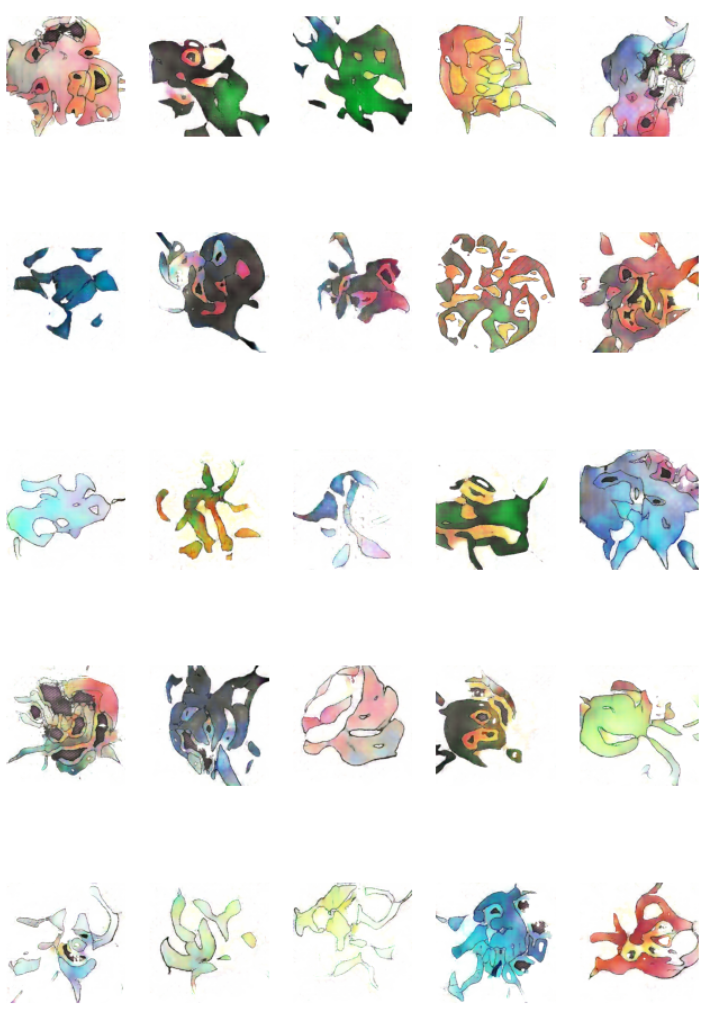

# Conclusion
Although the current results may not be as promising as expected, it is encouraging to see that the model is learning the patterns more effectively compared to the **[previous version](https://www.kaggle.com/code/rajatvisitme/pokegan-1-0)** (which lacked data augmentation). This indicates that progress is being made, and **there is potential for even better results with some modifications to the architecture or with different models.**
  
If you have made it this far, I kindly request you to consider giving a star ⭐ to this repository!!. Your support and encouragement mean a lot!
  
Furthermore, **I welcome any suggestions or feedback you may have.** Your insights can help me explore different methods and improve the outcomes.
  
Let's keep pushing forward and exploring new possibilities!

You can find the dataset here: [Pokemon Image Dataset v2](https://www.kaggle.com/datasets/rajatvisitme/pokemon-image-dataset-v2)


**Thank You**

# Saving Models on GDrive

In [ ]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil

In [ ]:
shutil.copy("/content/PokeGAN_v2_generator.h5","/content/drive/MyDrive/PokeGAN/v2")
shutil.copy("/content/PokeGAN_v2_discriminator.h5","/content/drive/MyDrive/PokeGAN/v2")

# <center>E.O.F.</center>